# 16.2 RDD Estimation: Kernels and Bandwidth

**Chapter**: 16 - Regression Discontinuity Design  
**Section**: 2 - Local Linear Regression  
**Facure Source**: 16-Regression-Discontinuity-Design.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Bandwidth Tradeoff](#11-the-bandwidth-tradeoff)
   - 1.2 [Kernel Weighting](#12-kernel-weighting)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Local Linear Regression](#21-local-linear-regression)
   - 2.2 [The Triangular Kernel](#22-the-triangular-kernel)
   - 2.3 [Optimal Bandwidth Selection](#23-optimal-bandwidth-selection)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Kernel Weighting in Action](#31-kernel-weighting-in-action)
   - 3.2 [Bandwidth Sensitivity](#32-bandwidth-sensitivity)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm, smf,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: Bandwidth selection is the core practical challenge in RDD. Understanding the bias-variance tradeoff and kernel weighting shows methodological sophistication.

### 1.1 The Bandwidth Tradeoff

Facure presents the fundamental RDD dilemma:

**Narrow bandwidth** (use only observations very close to cutoff):
- ✓ More credible "local randomization"
- ✓ Less bias from functional form misspecification
- ✗ Few observations → high variance

**Wide bandwidth** (use more observations):
- ✓ More data → lower variance
- ✗ Farther observations are less comparable
- ✗ More sensitive to functional form assumptions

### 1.2 Kernel Weighting

Solution: **Weight observations by distance from cutoff.**

Observations closer to the cutoff get more weight. This balances:
- Using nearby observations (credibility)
- Including more data (precision)

★ Insight ─────────────────────────────────────
- Bandwidth controls the bias-variance tradeoff
- Kernel weights make the transition smooth
- No single "correct" bandwidth—sensitivity analysis is essential
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Local Linear Regression

The RDD estimator uses **local linear regression**: fit separate lines on each side of the cutoff.

**Estimator**:

$$\hat{\tau} = \hat{\mu}_+ - \hat{\mu}_-$$

where $\hat{\mu}_+$ and $\hat{\mu}_-$ are the predicted values at the cutoff from regressions on each side.

**Weighted Least Squares formulation**:

$$\min_{\alpha, \beta, \tau, \delta} \sum_{i=1}^n K\left(\frac{R_i - c}{h}\right) \left[Y_i - \alpha - \beta(R_i - c) - \tau D_i - \delta D_i(R_i - c)\right]^2$$

where:
- $K(\cdot)$: Kernel function (weights)
- $h$: Bandwidth
- $R_i - c$: Centered running variable
- $D_i = \mathbf{1}\{R_i \geq c\}$: Treatment indicator

The coefficient $\tau$ is the RDD estimate.

### 2.2 The Triangular Kernel

**Triangular kernel** (most common in RDD):

$$K(u) = (1 - |u|) \cdot \mathbf{1}\{|u| \leq 1\}$$

**Properties**:
- Weight = 1 at cutoff ($u = 0$)
- Weight decreases linearly with distance
- Weight = 0 at bandwidth boundary ($|u| = 1$)

**Why triangular?**

**Proposition (Cheng, Fan, and Marron, 1997)**: For boundary estimation (which RDD is), the triangular kernel is optimal in a minimax MSE sense among all kernels.

**Proof sketch**:
- RDD estimates at the boundary (cutoff)
- At boundaries, kernels that put more weight on interior points dominate
- Triangular kernel minimizes asymptotic MSE at boundaries

### 2.3 Optimal Bandwidth Selection

**The bias-variance tradeoff formally**:

$$\text{MSE}(\hat{\tau}) = \text{Bias}^2(\hat{\tau}) + \text{Var}(\hat{\tau})$$

As bandwidth $h \to 0$:
- Bias → 0 (less extrapolation)
- Variance → ∞ (fewer observations)

As bandwidth $h \to \infty$:
- Bias → large (global regression)
- Variance → small (all data)

**Imbens-Kalyanaraman (IK) Optimal Bandwidth**:

$$h_{\text{IK}} = C_K \cdot \left(\frac{\sigma^2(c)}{f(c) \cdot (m''_+(c) - m''_-(c))^2}\right)^{1/5} \cdot n^{-1/5}$$

where:
- $\sigma^2(c)$: Conditional variance at cutoff
- $f(c)$: Density of running variable at cutoff
- $m''_\pm(c)$: Second derivatives of regression functions
- $C_K$: Kernel-dependent constant

**Practical note**: Use `rdrobust` package which implements Calonico-Cattaneo-Titiunik (CCT) bandwidth with robust bias correction.

★ Insight ─────────────────────────────────────
- Triangular kernel is optimal for boundary estimation
- Optimal bandwidth balances bias and variance
- Always report sensitivity to bandwidth choice
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 Kernel Weighting in Action

In [2]:
# Load MLDA data
drinking = load_facure_data('drinking.csv')
drinking['age_centered'] = drinking['agecell'] - 21
drinking['above_21'] = (drinking['age_centered'] >= 0).astype(int)

print(f"Data: {len(drinking)} age cells")
print(f"Age range: {drinking['agecell'].min():.1f} to {drinking['agecell'].max():.1f}")

Data: 50 age cells
Age range: 19.1 to 22.9


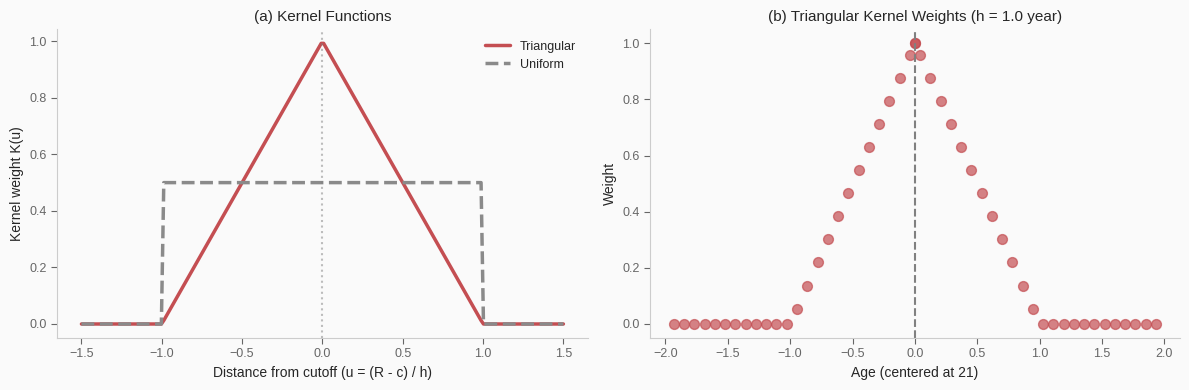


With bandwidth h = 1.0 year:
  Observations with weight > 0: 26 / 50
  Max weight (at cutoff): 1.000


In [3]:
def triangular_kernel(distance, bandwidth):
    """Triangular kernel: K(u) = (1 - |u|) * I(|u| <= 1)"""
    u = np.abs(distance) / bandwidth
    weights = np.where(u <= 1, 1 - u, 0)
    return weights

def uniform_kernel(distance, bandwidth):
    """Uniform kernel: K(u) = 0.5 * I(|u| <= 1)"""
    u = np.abs(distance) / bandwidth
    weights = np.where(u <= 1, 0.5, 0)
    return weights

# Visualize kernel functions
fig, axes = create_tufte_figure(1, 2, figsize=(12, 4))

# Panel 1: Kernel shapes
ax = axes[0]
u_vals = np.linspace(-1.5, 1.5, 200)

ax.plot(u_vals, [triangular_kernel(u, 1) for u in u_vals], 
        color=TUFTE_PALETTE['effect'], linewidth=2.5, label='Triangular')
ax.plot(u_vals, [uniform_kernel(u, 1) for u in u_vals], 
        color=TUFTE_PALETTE['secondary'], linewidth=2.5, linestyle='--', label='Uniform')
ax.axvline(0, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel('Distance from cutoff (u = (R - c) / h)')
ax.set_ylabel('Kernel weight K(u)')
ax.set_title('(a) Kernel Functions')
ax.legend(frameon=False)

# Panel 2: Weights applied to MLDA data
ax = axes[1]
bandwidth = 1.0  # 1 year

weights = triangular_kernel(drinking['age_centered'], bandwidth)

ax.scatter(drinking['age_centered'], weights, 
           c=TUFTE_PALETTE['effect'], s=50, alpha=0.7)
ax.axvline(0, color='gray', linestyle='--', linewidth=1.5)
ax.set_xlabel('Age (centered at 21)')
ax.set_ylabel('Weight')
ax.set_title(f'(b) Triangular Kernel Weights (h = {bandwidth} year)')

plt.tight_layout()
plt.show()

print(f"\nWith bandwidth h = {bandwidth} year:")
print(f"  Observations with weight > 0: {(weights > 0).sum()} / {len(weights)}")
print(f"  Max weight (at cutoff): {weights.max():.3f}")

In [4]:
def rdd_local_linear(data, outcome, bandwidth, kernel='triangular'):
    """
    Local linear RDD estimation with kernel weighting.
    
    Model: Y = α + β(R-c) + τD + δD(R-c) + ε
    Weighted by kernel function.
    """
    # Compute weights
    if kernel == 'triangular':
        weights = triangular_kernel(data['age_centered'], bandwidth)
    else:
        weights = uniform_kernel(data['age_centered'], bandwidth)
    
    # Filter to observations within bandwidth
    in_bandwidth = weights > 0
    data_bw = data[in_bandwidth].copy()
    weights_bw = weights[in_bandwidth]
    
    # WLS regression
    model = smf.wls(
        f'{outcome} ~ age_centered * above_21',
        data=data_bw,
        weights=weights_bw
    ).fit()
    
    return {
        'estimate': model.params['above_21'],
        'se': model.bse['above_21'],
        'n_effective': in_bandwidth.sum(),
        'bandwidth': bandwidth,
        'model': model
    }

# Estimate with different bandwidths
print("RDD ESTIMATES: Triangular Kernel")
print("=" * 70)
print(f"{'Bandwidth':>10} {'Estimate':>12} {'SE':>10} {'95% CI':>25} {'N_eff':>8}")
print("-" * 70)

bandwidths = [0.5, 1.0, 1.5, 2.0, 3.0]
results = []

for h in bandwidths:
    res = rdd_local_linear(drinking, 'all', h, 'triangular')
    ci_low = res['estimate'] - 1.96 * res['se']
    ci_high = res['estimate'] + 1.96 * res['se']
    
    print(f"{h:>10.1f} {res['estimate']:>12.4f} {res['se']:>10.4f} [{ci_low:>9.4f}, {ci_high:>9.4f}] {res['n_effective']:>8}")
    results.append(res)

RDD ESTIMATES: Triangular Kernel
 Bandwidth     Estimate         SE                    95% CI    N_eff
----------------------------------------------------------------------
       0.5       9.5667     2.2813 [   5.0953,   14.0381]       14
       1.0       9.7004     1.5342 [   6.6934,   12.7074]       26
       1.5       9.2873     1.2720 [   6.7942,   11.7803]       38
       2.0       8.3813     1.1247 [   6.1770,   10.5857]       50
       3.0       7.9960     1.1885 [   5.6666,   10.3255]       50


### 3.2 Bandwidth Sensitivity

A critical RDD diagnostic: **How sensitive is the estimate to bandwidth choice?**

In [5]:
# Bandwidth sensitivity analysis
bandwidth_range = np.linspace(0.3, 3.0, 30)
sensitivity = []

for h in bandwidth_range:
    res = rdd_local_linear(drinking, 'all', h, 'triangular')
    sensitivity.append({
        'bandwidth': h,
        'estimate': res['estimate'],
        'se': res['se'],
        'ci_low': res['estimate'] - 1.96 * res['se'],
        'ci_high': res['estimate'] + 1.96 * res['se'],
        'n_eff': res['n_effective']
    })

sens_df = pd.DataFrame(sensitivity)

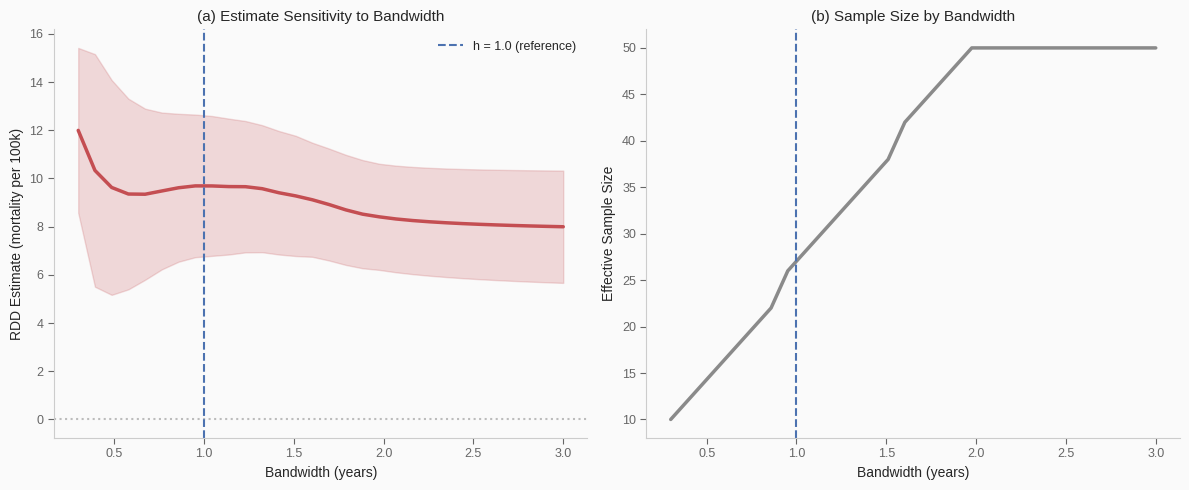

In [6]:
# Visualize bandwidth sensitivity
fig, axes = create_tufte_figure(1, 2, figsize=(12, 5))

# Panel 1: Estimate by bandwidth
ax = axes[0]
ax.fill_between(sens_df['bandwidth'], sens_df['ci_low'], sens_df['ci_high'],
                color=TUFTE_PALETTE['effect'], alpha=0.2)
ax.plot(sens_df['bandwidth'], sens_df['estimate'], 
        color=TUFTE_PALETTE['effect'], linewidth=2.5)
ax.axhline(0, color='gray', linestyle=':', alpha=0.5)

# Mark "typical" bandwidth
typical_h = 1.0
ax.axvline(typical_h, color=TUFTE_PALETTE['treatment'], linestyle='--', 
           linewidth=1.5, label=f'h = {typical_h} (reference)')

ax.set_xlabel('Bandwidth (years)')
ax.set_ylabel('RDD Estimate (mortality per 100k)')
ax.set_title('(a) Estimate Sensitivity to Bandwidth')
ax.legend(frameon=False)

# Panel 2: Effective sample size
ax = axes[1]
ax.plot(sens_df['bandwidth'], sens_df['n_eff'], 
        color=TUFTE_PALETTE['secondary'], linewidth=2.5)
ax.axvline(typical_h, color=TUFTE_PALETTE['treatment'], linestyle='--', linewidth=1.5)

ax.set_xlabel('Bandwidth (years)')
ax.set_ylabel('Effective Sample Size')
ax.set_title('(b) Sample Size by Bandwidth')

plt.tight_layout()
plt.show()

In [7]:
# Compare kernel types
print("\nKERNEL COMPARISON (h = 1.0)")
print("=" * 50)

for kernel in ['triangular', 'uniform']:
    res = rdd_local_linear(drinking, 'all', 1.0, kernel)
    print(f"\n{kernel.capitalize()} kernel:")
    print(f"  Estimate: {res['estimate']:.4f}")
    print(f"  SE:       {res['se']:.4f}")
    print(f"  N_eff:    {res['n_effective']}")


KERNEL COMPARISON (h = 1.0)

Triangular kernel:
  Estimate: 9.7004
  SE:       1.5342
  N_eff:    26

Uniform kernel:
  Estimate: 9.7533
  SE:       1.9371
  N_eff:    26


**Key observations**:

1. **Estimate varies with bandwidth**: Larger bandwidth → estimate changes (potential bias)
2. **Precision varies with bandwidth**: Larger bandwidth → smaller SE (more data)
3. **Triangular vs. Uniform**: Triangular is theoretically preferred; estimates are similar
4. **Robustness**: If estimate is stable across reasonable bandwidths → more credible

---

## Additional Content: Bandwidth Selection Methods

### IK vs CCT Bandwidth: When to Use Each

**Imbens-Kalyanaraman (IK, 2012)**:
- Minimizes **mean squared error** (MSE) of the point estimate
- Balances bias² and variance
- Standard choice for many years

**Calonico-Cattaneo-Titiunik (CCT, 2014)**:
- Accounts for **bias in inference**—CIs with IK bandwidth have wrong coverage
- Provides **robust bias-corrected confidence intervals**
- CCT bandwidth is typically 1.5-2× larger than IK
- Currently the recommended approach

**Practical guidance**:
| Situation | Recommendation |
|-----------|----------------|
| Point estimate focus | IK bandwidth |
| Inference/CI focus | CCT with robust bias correction |
| Publication | CCT is now standard |
| Sensitivity | Report both, plus 0.5×, 2× multipliers |

### McCrary Test Limitations

The **McCrary (2008)** density test checks for manipulation at the cutoff. However:

**⚠️ WARNING: Low Power Issue**

The McCrary test has **notoriously low power**, especially with:
- Small sample sizes (n < 1000)
- Running variables with discrete support
- Moderate manipulation amounts

**Key limitations**:
1. **Failure to reject ≠ no manipulation**: The test may miss even substantial manipulation
2. **Discrete running variables**: Test assumes continuous running variable; discrete data (e.g., test scores) requires different approach
3. **Compound treatments**: Even without manipulation, density bunching may occur naturally

**Recommendations**:
- Report McCrary test but interpret cautiously
- Conduct covariate balance tests at cutoff
- Use placebo cutoffs to check for spurious discontinuities
- Visual inspection is valuable but subjective

```python
# McCrary test with caution
from causal_inference.rdd import mccrary_test

result = mccrary_test(running_var, cutoff=c)
print(f"McCrary p-value: {result.pvalue:.4f}")
print("⚠️ Note: McCrary test has low power. Non-rejection does not confirm validity.")
```

★ Insight ─────────────────────────────────────
- CCT bandwidth with robust CIs is now the standard
- Always report sensitivity to bandwidth choice
- McCrary test has low power—non-rejection is weak evidence
- Combine McCrary with covariate balance tests and placebo cutoffs
─────────────────────────────────────────────────

---

## 4. Implementation

The `causal_inference_mastery` library provides RDD with optimal bandwidth:

```python
from causal_inference.rdd import sharp_rdd, RDDResult

# Sharp RDD with CCT bandwidth
result = sharp_rdd(
    outcome=data['mortality'],
    running_var=data['age'],
    cutoff=21,
    bandwidth='CCT',  # Calonico-Cattaneo-Titiunik
    kernel='triangular',
    polynomial=1,  # Local linear
    robust_se=True  # Bias-corrected CI
)

print(f"Optimal bandwidth: {result.bandwidth:.3f}")
print(f"Estimate: {result.estimate:.4f}")
print(f"Robust SE: {result.se_robust:.4f}")
print(f"Robust 95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")

# Sensitivity analysis
result.plot_sensitivity(bandwidth_range=[0.5, 2.0])
```

The production implementation includes:
- IK and CCT optimal bandwidth selection
- Bias-corrected robust standard errors
- Covariate adjustment option
- Automatic sensitivity plots

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Meta E5, DS)**: *"Why do we use a triangular kernel instead of uniform kernel in RDD?"*

<details>
<summary>Solution</summary>

**Theoretical reason**: Triangular kernel is MSE-optimal for boundary estimation.

**Intuition**:

1. **RDD is boundary estimation**: We estimate at the cutoff, which is at the boundary of the support for each side

2. **At boundaries, interior points are more informative**:
   - For estimating the limit from the left at $c$, points at $c - \epsilon$ are more useful than points at $c - h$
   - Triangular kernel weights interior points more heavily

3. **Formal result (Cheng, Fan, Marron 1997)**:
   - Among all nonnegative kernel functions
   - Triangular kernel minimizes the asymptotic MSE
   - For boundary estimation specifically (not interior)

4. **Practical difference**:
   - Often small in practice
   - Triangular is standard, provides theoretical optimality
   - Uniform is simpler to explain but slightly less efficient

**Key point**: It's about boundary estimation, not general kernel regression. At boundaries, triangular dominates.

</details>

---

**Q2 (Google L5, Quant)**: *"How do you choose bandwidth in RDD? What's the tradeoff?"*

<details>
<summary>Solution</summary>

**The bias-variance tradeoff**:

| Bandwidth | Bias | Variance | Credibility |
|-----------|------|----------|-------------|
| Narrow | Low | High | High (local randomization) |
| Wide | High | Low | Lower (more extrapolation) |

**Bandwidth selection methods**:

1. **Imbens-Kalyanaraman (IK)**:
   - MSE-optimal bandwidth
   - Balances bias² and variance
   - Standard in economics

2. **Calonico-Cattaneo-Titiunik (CCT)**:
   - Accounts for bias in coverage
   - Provides robust bias-corrected CIs
   - Currently preferred method

3. **Cross-validation**:
   - Leave-one-out prediction error
   - Data-driven but can overfit

**Best practice**:
1. Report main results with CCT optimal bandwidth
2. Show sensitivity: 0.5h, h, 1.5h, 2h
3. If results flip sign across reasonable bandwidths → be cautious
4. Never "shop" for bandwidth that gives desired result

</details>

---

**Q3 (Amazon L6, Econ)**: *"Your RDD estimate is 5.0 with h=1 and 8.0 with h=2. What do you conclude?"*

<details>
<summary>Solution</summary>

**This is a red flag for specification sensitivity.**

**Possible explanations**:

1. **Functional form misspecification**:
   - True relationship is nonlinear
   - Linear approximation worsens with wider bandwidth
   - **Fix**: Try higher-order polynomial, or stick with narrow bandwidth

2. **Heterogeneous effects**:
   - Effect differs for observations far from cutoff
   - Wider bandwidth includes different populations
   - **Interpretation**: Local effect (h=1) differs from global

3. **Confounding far from cutoff**:
   - Continuity assumption holds near cutoff but breaks down farther away
   - Narrow bandwidth more credible

**What to report**:
1. Acknowledge the sensitivity explicitly
2. Trust narrower bandwidth (more credible local randomization)
3. Report both, explain why they differ
4. Consider whether research question is about local or broader effect

**Key point**: Sensitivity to bandwidth suggests the estimate is fragile. Don't hide this—address it transparently.

</details>

---

## 6. References

[^1]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 16: "Regression Discontinuity Design."

[^2]: Imbens, G. W. and Kalyanaraman, K. (2012). Optimal Bandwidth Choice for the Regression Discontinuity Estimator. *Review of Economic Studies*, 79(3), 933-959.

[^3]: Calonico, S., Cattaneo, M. D., and Titiunik, R. (2014). Robust Nonparametric Confidence Intervals for Regression-Discontinuity Designs. *Econometrica*, 82(6), 2295-2326.

[^4]: Cheng, M.-Y., Fan, J., and Marron, J. S. (1997). On Automatic Boundary Corrections. *Annals of Statistics*, 25(4), 1691-1708.

[^5]: Cattaneo, M. D., Idrobo, N., and Titiunik, R. (2020). *A Practical Introduction to Regression Discontinuity Designs: Foundations*. Cambridge University Press.

---

**Precision Improvement:**
- You said: "Build RDD estimation notebook"
- Concise: "Build 02_rdd_estimation.ipynb"
- Precise: `/facure_augment 16.2 --kernel-weighting --bandwidth-selection --sensitivity`
- Pattern: [build] [target] [content-flags]